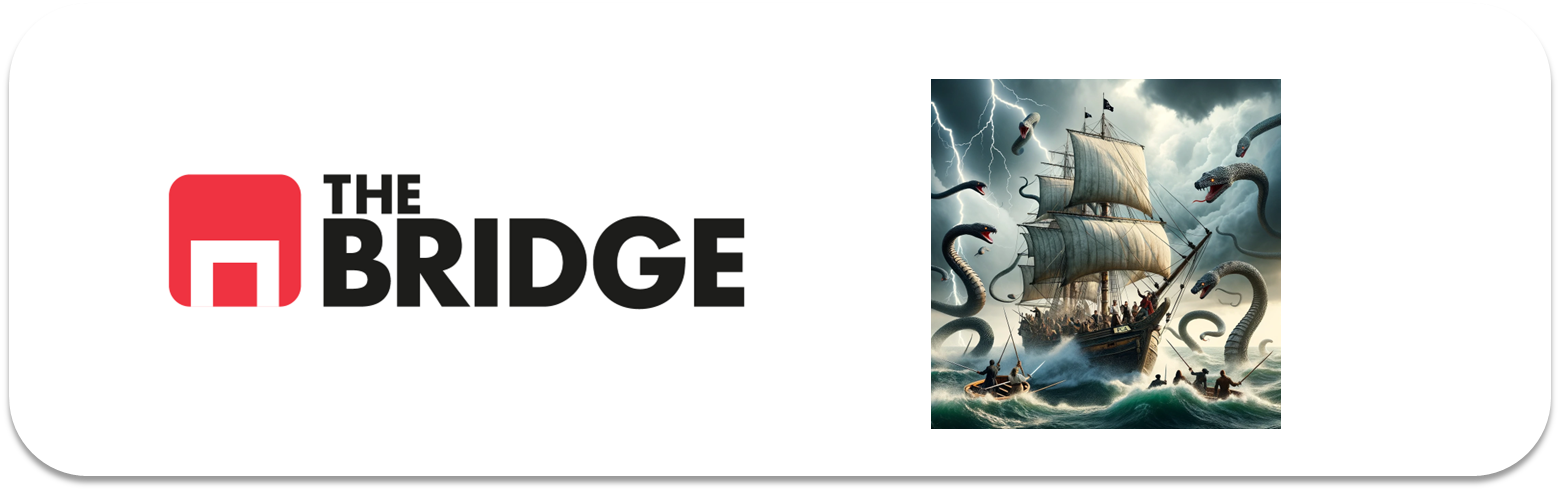

## PRACTICA OBLIGATORIA: **No Supervisado: PCA**

* La práctica obligatoria de esta unidad consiste en aplicar PCA a un dataset de imágenes con diferentes objetivos y compromisos. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### El problema de negocio

El Caesar Palace de las Vegas está planificando la instalación de mil quininetas microcámaras en los accesos a sus instalaciones para las próximas sesiones del "Poker World Championship". Estas microcámaras tienen la peculiaridad de que son capaces de tomar fotos encuadradas de las caras y la desventaja de que no tienen un gran ancho de banda de comunicación. (Las había de más ancho y de mayor precio...). NOTA: El ancho de banda limita el tamaño de las imágenes que pueden enviar las microcámaras).

El objetivo de las microcámaras es el de detectar personas "non-gratas" en tiempo real, pudiendo posprocesar las imágenes para poder detectar si han accedido a las instalaciones personas que estuvieran perseguidas por la ley, en los bancos de datos de los casinos identificadas como "peligrosas" (no se sabe si para el resto de personas o para los beneficios de los casinos) y en las listas de no admisión de jugadores adictos. Por eso no necesitan procesar los datos en tiempo real, pero sí enviarlos a un repositorio central. 

¿Cuál es su problema? O bien comprimen las imágenes y las procesan comprimidas en cada microcámara (pueden comprimir muy rápido pero no tienen cpu para procesarlas sin comprimir) o bien las comprimen y las mandan a un servidor central muy rápido (por eso ti) donde se descomprimirían y se analizarían. Analizar quiere decir en este contexto, pasarles un modelo de clasificación que determine si la persona de la imagen es una de las listas prohibidas (o sea que clasifique la imágen).  

Nos han enviado un dataset y con él debemos estudiar cuál de las dos soluciones es más interesante y dar recomendaciones al respecto. Vamos a ello.

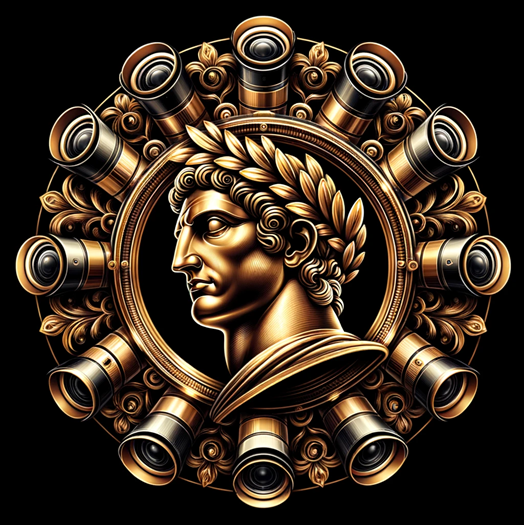

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

### #1 MODELO DE BASE

**Objetivo:** Construir un modelo baseline de clasficación de imágenes que las trate sin comprimir (es decir usando todos sus píxeles).

Para conseguir el objetivo, primero descarga el dataset de las caras de Olivetti que ya has utilizado anteriormente, empleando las funciones de sklearn necesarias. Luego, construye un clasificador con el modelo que consideres más apropiado y todas las features del dataset. Eso sí, recuerda hacer lo siguiente:

1. Construir un data frame con los datos 
2. Hacer un split en train y test con al menos 80 instancias en el test y estratificado según el target. Este split se ha de mantener en el resto de la práctica
3. Hacer un quick miniEDA o justificar el no hacerlo.
4. Medir la recall media (“balanced_accuracy”) sobre cross validation con 5 folds y sobre el conjunto de test y guarda ambas para usarlas como baseline en las siguientes partes




In [3]:
faces = fetch_olivetti_faces()
X, y = faces.data, faces.target

df = pd.DataFrame(X)
df['target'] = y

df.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,...,0.669421,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025,0
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,...,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893,0
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,...,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893,0
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,...,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669,0
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,...,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554,0


In [4]:
# División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=80, stratify=y, random_state=42)

In [5]:
# Modelo baseline
baseline_model = RandomForestClassifier(random_state=42)
baseline_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [6]:
# Validación cruzada
cv_scores = cross_val_score(baseline_model, X_train, y_train, cv=5, scoring='balanced_accuracy')
baseline_cv_score = np.mean(cv_scores)

In [7]:
# Evaluación conjunto de test
y_pred_test = baseline_model.predict(X_test)
baseline_test_score = balanced_accuracy_score(y_test, y_pred_test)

print(f'Baseline CV Score: {baseline_cv_score}')
print(f'Baseline Test Score: {baseline_test_score}')

Baseline CV Score: 0.9349999999999999
Baseline Test Score: 0.95


### #2 MODELO PARA LAS MICROCÁMARAS
**Objetivo:** Construir un modelo que pueda funcionar en las microcámaras, es decir que pueda funcionar con datos comprimidos.

Para cumplir con el objetivo se os ocurre emplear la doble propiedad de la PCA, que permite comprimir datos y mantener la capacidad informativa de estos. Sigue los siguientes pasos:
1. Instancia un objeto PCA sobre los datos de Train sin especificar ni componentes ni varianza explicada (o sea sin pasar argumentos).
2. Escoge un rango de valores para el número de PCAs que permitan por lo menos una compresión de la imagen de entre el 0.2% y el 2.5% (prueba al menos 5 valores). NOTA: La compresión es la reducción total, es decir una reducción del 1% quiere decir que el dataset se reduce a un 1% de su tamaño original)
3. Para el rango anterior entrena un modelo de clasificación y apunta su scoring en una validación cruzada de 5 folds y métrica el recall medio y su scoring contra test.
4. Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresión, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.
5. Escoge el número de componentes que permitirían tener la mayor compresión con una pérdida inferior a 3 puntos porcentuales tanto en CV como en test. Si no hay escoge el que tenga una pérdida inferior a 5 puntos porcentuales. 

In [8]:
# Instanciar PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

In [9]:
# Rango de compresión (0.2% a 2.5%)
compression_ratios = [0.002, 0.005, 0.01, 0.015, 0.025]
num_components = [int(ratio * X_train.shape[1]) for ratio in compression_ratios]

In [10]:

results = []

for n_components in num_components:
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    model = RandomForestClassifier(random_state=42)
    cv_scores = cross_val_score(model, X_train_pca, y_train, cv=5, scoring='balanced_accuracy')
    cv_score = np.mean(cv_scores)
    
    model.fit(X_train_pca, y_train)
    y_pred_test = model.predict(X_test_pca)
    test_score = balanced_accuracy_score(y_test, y_pred_test)
    
    compression = n_components / X_train.shape[1]
    
    results.append({
        'n_components': n_components,
        'CV Score': cv_score,
        'Test Score': test_score,
        'Compression': compression,
        'Diff CV': baseline_cv_score - cv_score,
        'Diff Test': baseline_test_score - test_score
    })

# Crear DataFrame
results_df = pd.DataFrame(results)
results_df

,n_components,CV Score,Test Score,Compression,Diff CV,Diff Test
0,8,0.8050,0.7625,0.001953,0.1300,0.1875
1,20,0.8900,0.9000,0.004883,0.0450,0.0500
2,40,0.9375,0.9375,0.009766,-0.0025,0.0125
3,61,0.9150,0.9500,0.014893,0.0200,0.0000
4,102,0.8825,0.9500,0.024902,0.0525,0.0000


In [11]:
# Escoger componentes (pérdida inferior a 3 puntos porcentuales)
best_components = results_df[(results_df['Diff CV'] <= 0.05) & (results_df['Diff Test'] <= 0.03)].sort_values('Compression').iloc[0]
print(f'Mejor Número de Componentes: {best_components["n_components"]}')

Mejor Número de Componentes: 40.0


### #3 COMPRESION PARA CLASIFICACION POSTERIOR

**Objetivo**: Obtener el número de componentes que permita una compresión menor y al tiempo que el modelo en el servidor central no baje su rendimiento respecto a no usar imágenes comprimidas.

Para esta parte la idea que se os ha ocurrido es emplear también la PCA como compresor ya que así siempre podrían pasar a la opción anterior si eso fuese suficiente. Pero en este caso no vamos a utilizar el dataset comprimido con las PCAs para detectar las caras, sino el dataset una vez descomprimido (recuerda que puede emplear `inverse_transform` para "descomprimir"). Los pasos a seguir son:

1. Escoge un rango de valores que  permitan una compresión aún mayor (recuerda que el ancho de banda es mínimo) entre el 1 por mil y el 1 por ciento. Escoge 5 valores de número de PCAs que permitan movernos en ese rango.
2. Para cada uno de esos valores: aplica la PCA al X_train, obten un X_train_unzipped aplicando la inversa de la PCA y entrena un modelo de clasificación y pruébalo contra test, apunta el balanced accuracy.
3. Crea un dataframe o haz un visualización comparando como es la medidad de balance accuracy para cada valor de número de pcas escogido y cuál su factor de compresión. 
4. Sabiendo que no podemos perder más de 3 puntos porcentuales respecto al baseline, ¿qué numero de PCA escogerías?

In [12]:
# Definir rango de compresión (0.1% a 1%)
compression_ratios_high = [0.001, 0.002, 0.003, 0.005, 0.01]
num_components_high = [int(ratio * X_train.shape[1]) for ratio in compression_ratios_high]

In [13]:
results_high = []

for n_components in num_components_high:
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_train_unzipped = pca.inverse_transform(X_train_pca)
    X_test_pca = pca.transform(X_test)
    X_test_unzipped = pca.inverse_transform(X_test_pca)
    
    model = RandomForestClassifier(random_state=42)
    cv_scores = cross_val_score(model, X_train_unzipped, y_train, cv=5, scoring='balanced_accuracy')
    cv_score = np.mean(cv_scores)
    
    model.fit(X_train_unzipped, y_train)
    y_pred_test = model.predict(X_test_unzipped)
    test_score = balanced_accuracy_score(y_test, y_pred_test)
    
    compression = n_components / X_train.shape[1]
    
    results_high.append({
        'n_components': n_components,
        'CV Score': cv_score,
        'Test Score': test_score,
        'Compression': compression,
        'Diff CV': baseline_cv_score - cv_score,
        'Diff Test': baseline_test_score - test_score
    })

# Crear DataFrame
results_high_df = pd.DataFrame(results_high)
results_high_df

,n_components,CV Score,Test Score,Compression,Diff CV,Diff Test
0,4,0.6175,0.5750,0.000977,0.3175,0.3750
1,8,0.7725,0.7625,0.001953,0.1625,0.1875
2,12,0.8250,0.8500,0.002930,0.1100,0.1000
3,20,0.9000,0.9000,0.004883,0.0350,0.0500
4,40,0.9275,0.9375,0.009766,0.0075,0.0125


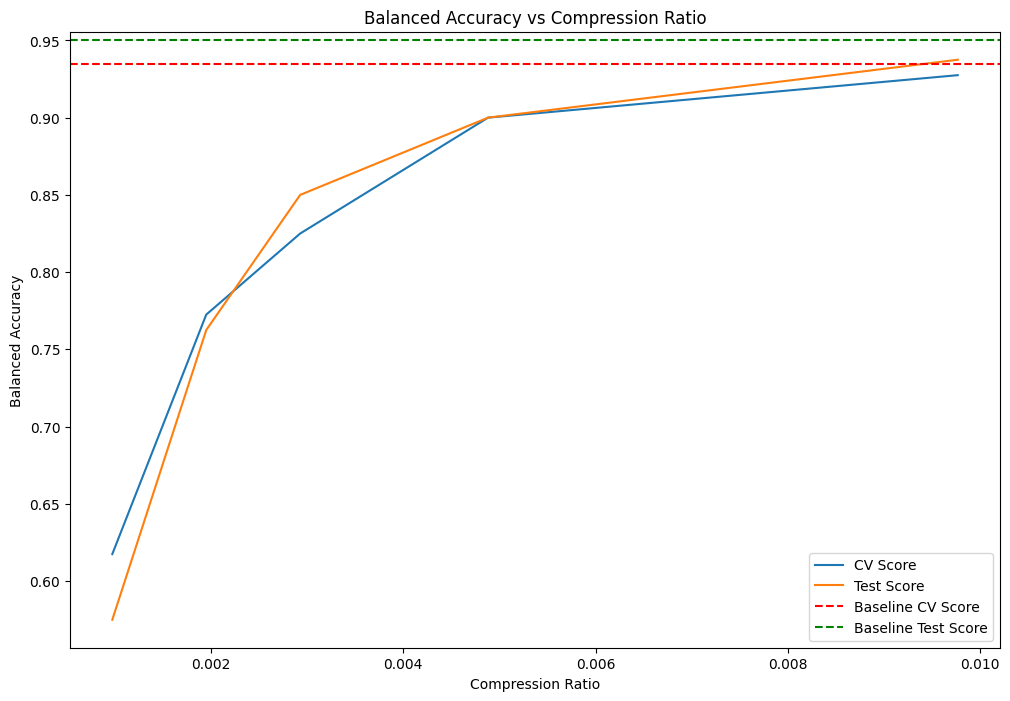

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(results_high_df['Compression'], results_high_df['CV Score'], label='CV Score')
plt.plot(results_high_df['Compression'], results_high_df['Test Score'], label='Test Score')
plt.axhline(baseline_cv_score, color='r', linestyle='--', label='Baseline CV Score')
plt.axhline(baseline_test_score, color='g', linestyle='--', label='Baseline Test Score')
plt.xlabel('Compression Ratio')
plt.ylabel('Balanced Accuracy')
plt.legend()
plt.title('Balanced Accuracy vs Compression Ratio')
plt.show()

In [15]:
# Número de componentes (pérdida inferior a 3 puntos)
best_components_high = results_high_df[(results_high_df['Diff CV'] <= 0.03) & (results_high_df['Diff Test'] <= 0.03)].sort_values('Compression').iloc[0]
print(f'Mejor Número de Componentes (Alta Compresión): {best_components_high["n_components"]}')

Mejor Número de Componentes (Alta Compresión): 40.0


### #EXTRA

1. Para la segunda parte, visualiza en cuatro gráficos un scatter plot de las dos primeras componentes principales de la PCA escogida y colorea cada punto con las clases correspondientes a cada cara (como hay 40 clases, usa 10 por gráfico, 1-10 en el primero, 11-20 en el segundo, etc)
2. Para la tercer parte crea una función (modifica la de la práctica de la unidad de KMeans, por ejemplo) que permita ver la cara sin comprimir y la cara después de haberla descomprimido y haz una comprobación de cómo quedan (visualiza 5 caras por ejemplo) para cada uno de los valores de números de PCAs probados. Añade el caso para 150 y 300 PCs para que se vea que son las mismas claras con claridad.

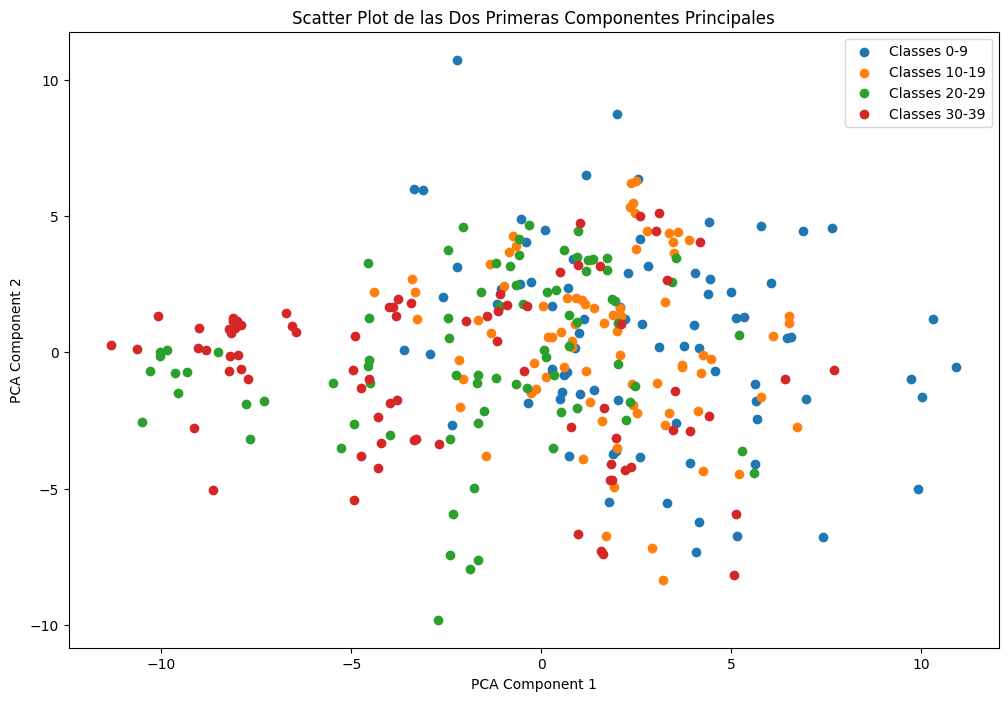

In [16]:
# Scatter plots
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

plt.figure(figsize=(12, 8))
for i in range(0, 40, 10):
    mask = (y_train >= i) & (y_train < i + 10)
    plt.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], label=f'Classes {i}-{i+9}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.title('Scatter Plot de las Dos Primeras Componentes Principales')
plt.show()

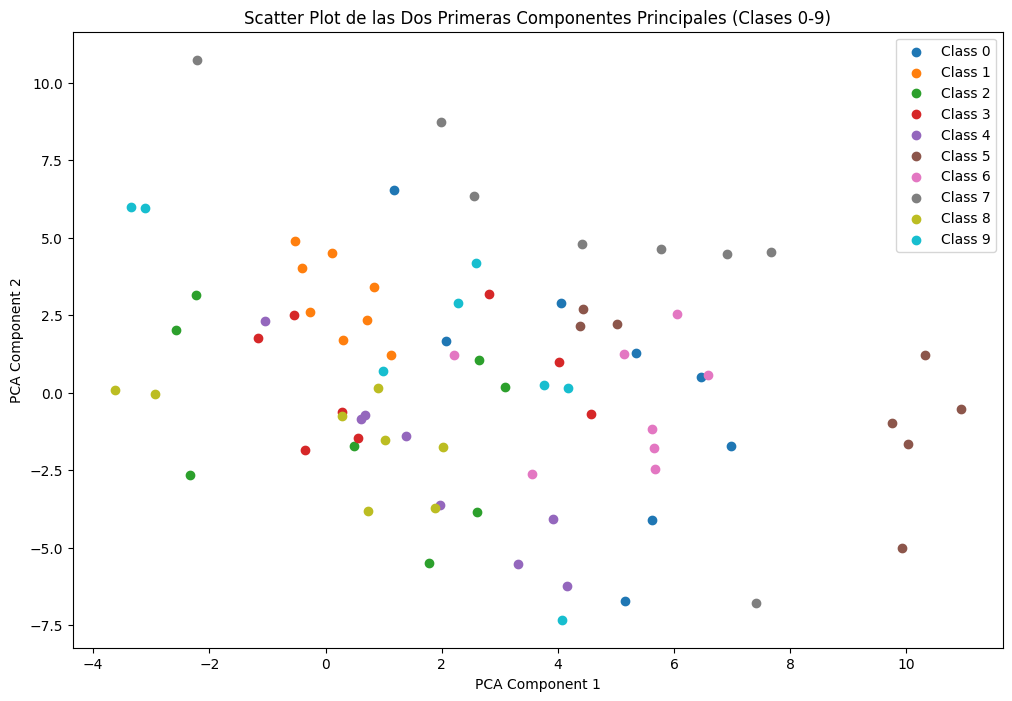

In [17]:
# Scatter plots (clases 0-9)
plt.figure(figsize=(12, 8))
for i in range(0, 10):
    mask = (y_train == i)
    plt.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], label=f'Class {i}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.title('Scatter Plot de las Dos Primeras Componentes Principales (Clases 0-9)')
plt.show()

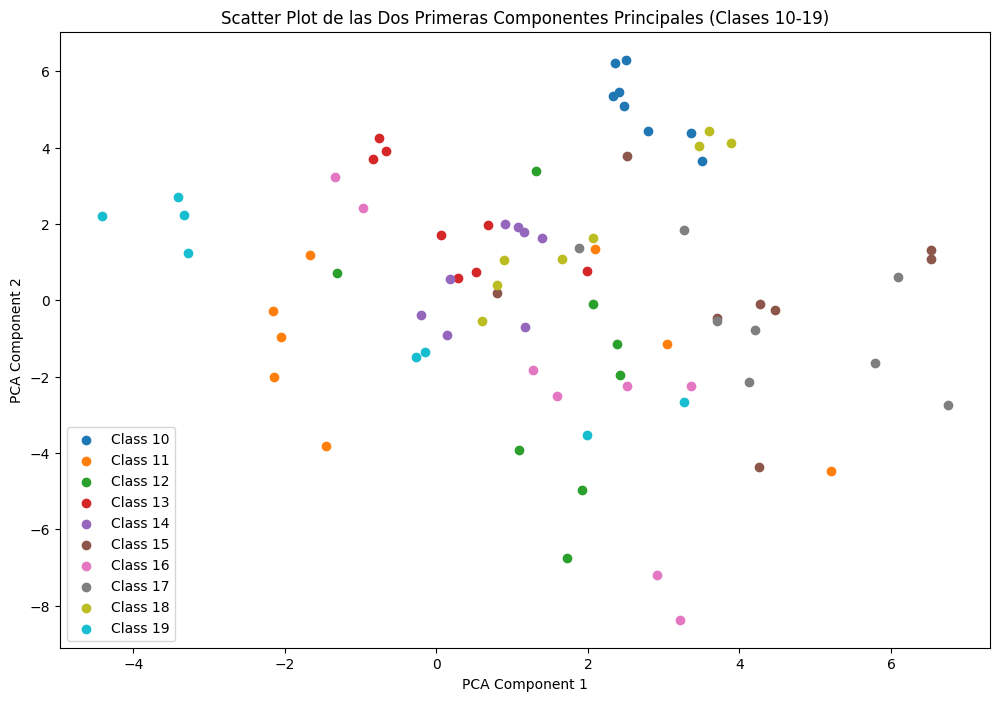

In [18]:
# Scatter plots (clases 10-19)
plt.figure(figsize=(12, 8))
for i in range(10, 20):
    mask = (y_train == i)
    plt.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], label=f'Class {i}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.title('Scatter Plot de las Dos Primeras Componentes Principales (Clases 10-19)')
plt.show()

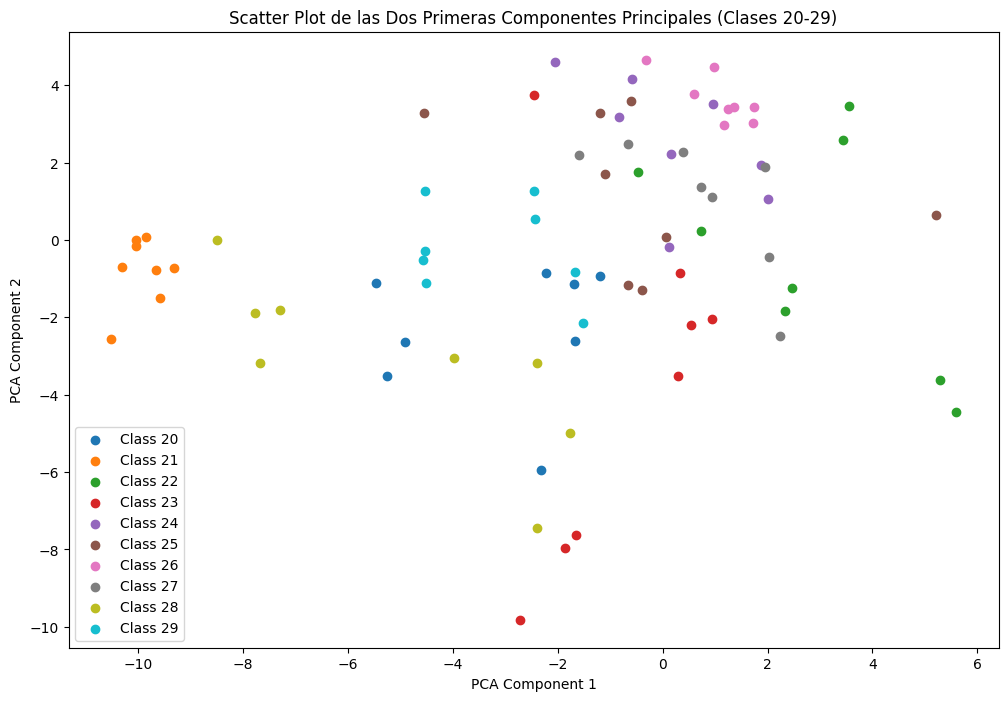

In [19]:
# Scatter plots (clases 20-29)
plt.figure(figsize=(12, 8))
for i in range(20, 30):
    mask = (y_train == i)
    plt.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], label=f'Class {i}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.title('Scatter Plot de las Dos Primeras Componentes Principales (Clases 20-29)')
plt.show()

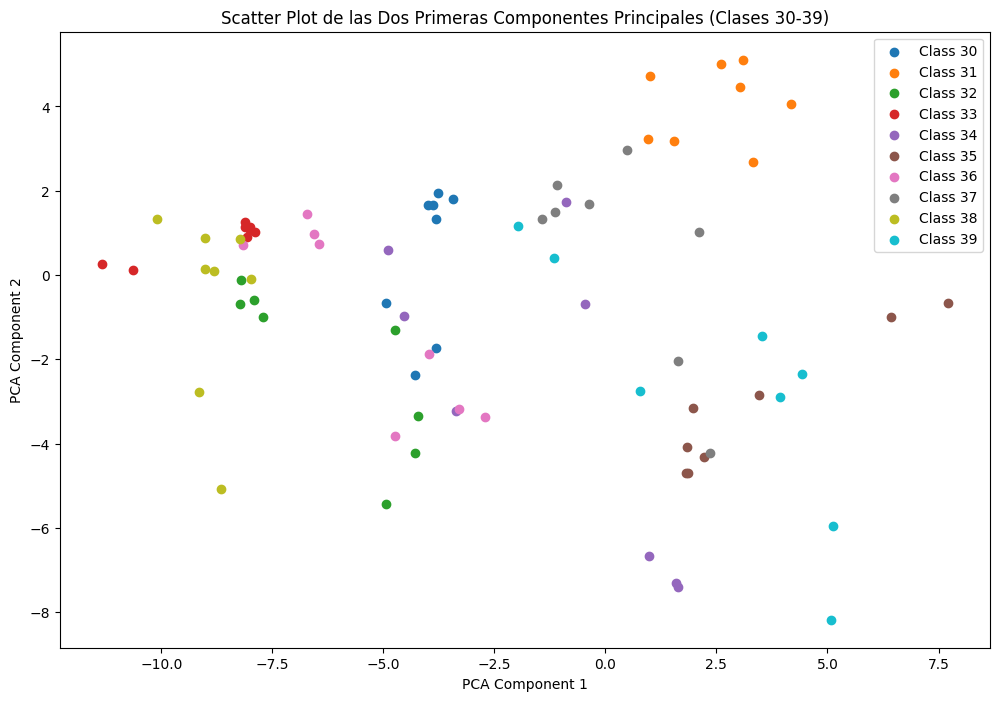

In [20]:
# Scatter plots (clases 30-39)
plt.figure(figsize=(12, 8))
for i in range(30, 40):
    mask = (y_train == i)
    plt.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], label=f'Class {i}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.title('Scatter Plot de las Dos Primeras Componentes Principales (Clases 30-39)')
plt.show()

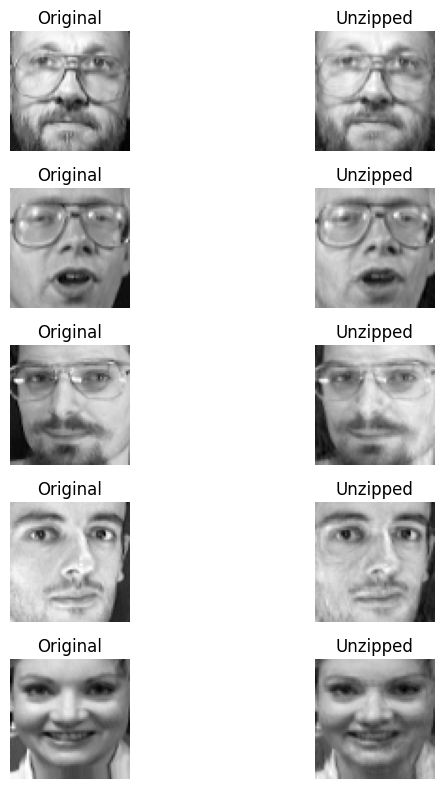

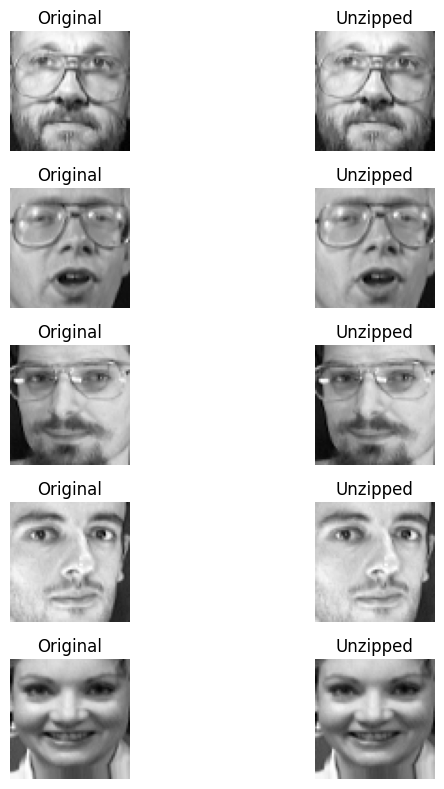

In [21]:
def plot_compressed_faces(pca, X, indices):
    X_pca = pca.transform(X)
    X_unzipped = pca.inverse_transform(X_pca)
    
    fig, axes = plt.subplots(len(indices), 2, figsize=(8, 8))
    for i, idx in enumerate(indices):
        axes[i, 0].imshow(X[idx].reshape((64, 64)), cmap='gray')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(X_unzipped[idx].reshape((64, 64)), cmap='gray')
        axes[i, 1].set_title('Unzipped')
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

indices = [0, 10, 20, 30, 40]
pca_150 = PCA(n_components=150).fit(X_train)
plot_compressed_faces(pca_150, X_train, indices)

pca_300 = PCA(n_components=300).fit(X_train)
plot_compressed_faces(pca_300, X_train, indices)